In [1]:
import os, json, random, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

for d in ["data/raw","data/processed","models","reports","figures"]:
    os.makedirs(d, exist_ok=True)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import joblib

SEED = 42
np.random.seed(SEED); random.seed(SEED)
print("Setup complete.")

Setup complete.


In [3]:
DATA_PATH = "data/raw/customer_churn.csv"
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.map(lambda c: str(c).strip())

# Standardize key names for the rest of the notebook
rename_map = {
    "customerID":"customer_id", "SeniorCitizen":"senior_citizen",
    "PhoneService":"phone_service", "MultipleLines":"multiple_lines",
    "InternetService":"internet_service", "OnlineSecurity":"online_security",
    "OnlineBackup":"online_backup", "DeviceProtection":"device_protection",
    "TechSupport":"tech_support", "StreamingTV":"streaming_tv",
    "StreamingMovies":"streaming_movies", "Contract":"contract_type",
    "PaperlessBilling":"autopay", "PaymentMethod":"payment_method",
    "MonthlyCharges":"monthly_charges", "TotalCharges":"total_charges",
    "Churn":"churn"
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Target to 0/1
if not pd.api.types.is_numeric_dtype(df["churn"]):
    df["churn"] = df["churn"].astype(str).str.strip().str.lower().map({"yes":1,"no":0,"1":1,"0":0})
# Clean numerics
df["total_charges"] = pd.to_numeric(df.get("total_charges"), errors="coerce")
df["monthly_charges"] = pd.to_numeric(df.get("monthly_charges"), errors="coerce")
# Fill occasional blanks in total_charges
if {"total_charges","monthly_charges","tenure"}.issubset(df.columns):
    df["total_charges"] = df["total_charges"].fillna(df["monthly_charges"] * df["tenure"])
# Autopay 0/1 if needed
if "autopay" in df.columns and df["autopay"].dtype == object:
    df["autopay"] = df["autopay"].astype(str).str.strip().map({"Yes":1,"No":0,"YES":1,"NO":0})

df = df.dropna(subset=["churn"]).drop_duplicates().copy()
df["churn"] = df["churn"].astype(int)
baseline_rate = df["churn"].mean()
print("Shape:", df.shape, "| Baseline churn:", round(baseline_rate,3))

Shape: (7043, 21) | Baseline churn: 0.265


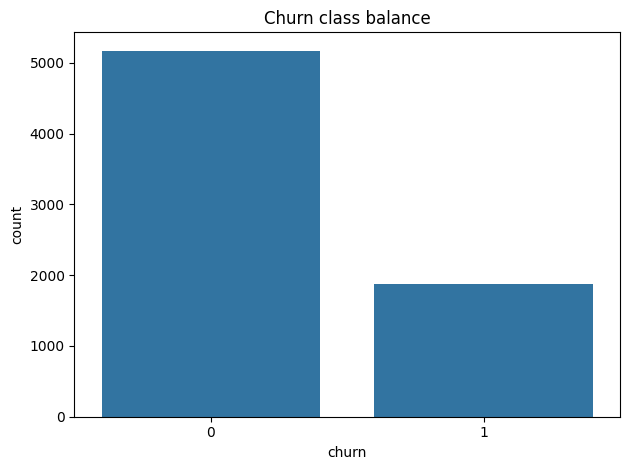

In [4]:
missing = df.isna().sum().sort_values(ascending=False)
with open("reports/data_quality.txt","w") as f:
    f.write("Missing (top 20):\n"); f.write(str(missing.head(20))+"\n")

sns.countplot(x="churn", data=df)
plt.title("Churn class balance")
plt.tight_layout(); plt.savefig("figures/target_balance.png"); plt.show()

In [5]:
denylist_exact = {"cancel_date","cancellation_flag","termination_reason","end_date","churn_date",
                  "churn score","churn reason","churn value","churn label","cltv","count"}
leak_cols = [c for c in df.columns if c.lower() in denylist_exact and c.lower()!="churn"]

id_cols = [c for c in df.columns if any(k in c.lower() for k in ["id","account","acct","customer","user"]) and c.lower()!="churn"]

features = [c for c in df.columns if c not in set(["churn"]+leak_cols+id_cols)]
print("Dropping leakage:", leak_cols, "| Using features:", len(features))

Dropping leakage: [] | Using features: 19


In [6]:
X_full, y_full = df[features].copy(), df["churn"].copy()
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=SEED)
split_mode = "stratified random"
print("Split:", split_mode, "| Shapes:", X_train.shape, X_test.shape)

Split: stratified random | Shapes: (5634, 19) (1409, 19)


In [7]:
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))])

preprocessor = ColumnTransformer([ ("num", num_pipe, num_sel), ("cat", cat_pipe, cat_sel) ])

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = ["roc_auc","precision","recall","f1"]

dummy = Pipeline([("prep", preprocessor), ("model", DummyClassifier(strategy="stratified", random_state=SEED))])
cv_dummy = cross_validate(dummy, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print({m: round(cv_dummy[f"test_{m}"].mean(),3) for m in scoring})

{'roc_auc': np.float64(0.507), 'precision': np.float64(0.275), 'recall': np.float64(0.278), 'f1': np.float64(0.276)}


In [9]:
logreg = Pipeline([ ("prep", preprocessor), ("model", LogisticRegression(max_iter=400, class_weight="balanced", solver="liblinear", random_state=SEED)) ])
cv_lr = cross_validate(logreg, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("CV Logistic:", {m: round(cv_lr[f"test_{m}"].mean(),3) for m in scoring})

CV Logistic: {'roc_auc': np.float64(0.846), 'precision': np.float64(0.517), 'recall': np.float64(0.801), 'f1': np.float64(0.628)}


In [10]:
dt = Pipeline([ ("prep", preprocessor), ("model", DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=SEED, class_weight="balanced")) ])
cv_dt = cross_validate(dt, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("CV DecisionTree:", {m: round(cv_dt[f"test_{m}"].mean(),3) for m in scoring})

CV DecisionTree: {'roc_auc': np.float64(0.693), 'precision': np.float64(0.48), 'recall': np.float64(0.593), 'f1': np.float64(0.53)}


In [11]:
rf_base = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=SEED))
])

param_dist = {
    "model__n_estimators": np.arange(250, 601, 50),
    "model__max_depth": np.arange(4, 21, 2),
    "model__min_samples_leaf": [1,2,3,4,5,8],
    "model__max_features": ["sqrt","log2", None]
}
rf_search = RandomizedSearchCV(rf_base, param_dist, n_iter=15, cv=cv, scoring="roc_auc", n_jobs=-1, random_state=SEED, verbose=0)
rf_search.fit(X_train, y_train)
rf = rf_search.best_estimator_
print("CV RandomForest AUC:", round(rf_search.best_score_,3))

CV RandomForest AUC: 0.847


In [12]:
gb = Pipeline([ ("prep", preprocessor), ("model", GradientBoostingClassifier(random_state=SEED)) ])
cv_gb = cross_validate(gb, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("CV GradBoost:", {m: round(cv_gb[f"test_{m}"].mean(),3) for m in scoring})

CV GradBoost: {'roc_auc': np.float64(0.848), 'precision': np.float64(0.662), 'recall': np.float64(0.529), 'f1': np.float64(0.588)}


In [13]:
#holdout validation

models = {
    "LogisticRegression": logreg.fit(X_train, y_train),
    "DecisionTree": dt.fit(X_train, y_train),
    "RandomForest": rf.fit(X_train, y_train),
    "GradientBoosting": gb.fit(X_train, y_train)
}

holdout_auc = {}
probas = {}
for name, m in models.items():
    p = m.predict_proba(X_test)[:,1]
    probas[name] = p
    holdout_auc[name] = roc_auc_score(y_test, p)

winner_label = max(holdout_auc, key=holdout_auc.get)
final_model = models[winner_label]
proba_test = probas[winner_label]
print("Selected:", winner_label, "| Holdout AUC:", round(holdout_auc[winner_label],3))

Selected: RandomForest | Holdout AUC: 0.844


In [23]:
# fintetune by setting throshold

prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1_curve = 2*(prec*rec)/(prec+rec + 1e-9)
best_thr = thr[np.nanargmax(f1_curve)] if len(thr) else 0.5

target_precision = 0.7
feasible = np.where(prec[:-1] >= target_precision)[0]
chosen_thr = float(thr[feasible[0]]) if len(feasible) else float(best_thr)

y_pred_test = (proba_test >= chosen_thr).astype(int)
auc = roc_auc_score(y_test, proba_test)
pr_auc = average_precision_score(y_test, proba_test)

print(f"AUC={auc:.3f} | PR-AUC={pr_auc:.3f} | thr={chosen_thr:.3f}")
print(f"precision={precision_score(y_test,y_pred_test):.3f} | recall={recall_score(y_test,y_pred_test):.3f} | f1={f1_score(y_test,y_pred_test):.3f}")
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits=3))

AUC=0.844 | PR-AUC=0.652 | thr=0.736
precision=0.702 | recall=0.460 | f1=0.556
[[962  73]
 [202 172]]
              precision    recall  f1-score   support

           0      0.826     0.929     0.875      1035
           1      0.702     0.460     0.556       374

    accuracy                          0.805      1409
   macro avg      0.764     0.695     0.715      1409
weighted avg      0.793     0.805     0.790      1409



In [24]:
cost_per_contact = 2.0
benefit_retained = 50.0
TP = ((y_test==1)&(y_pred_test==1)).sum()
FP = ((y_test==0)&(y_pred_test==1)).sum()
est_net = TP*benefit_retained - (TP+FP)*cost_per_contact
open("reports/roi.txt","w").write(f"Est. net impact @ thr {chosen_thr:.3f}: ${est_net:,.0f}\n")
print(f"Estimated net impact: ${est_net:,.0f}")

Estimated net impact: $8,110


In [25]:
# why the model behaves this way.  which features (columns) in your input data were most important to the model when it made its predictions

r = permutation_importance(final_model, X_test, y_test, n_repeats=5, random_state=SEED, scoring="roc_auc")
imp = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
imp.head(25).to_csv("reports/top_features.csv")
imp.head(10)

,0
contract_type,0.058555
tenure,0.025425
internet_service,0.017324
total_charges,0.013720
online_security,0.005561
tech_support,0.004207
payment_method,0.001653
streaming_movies,0.001149
multiple_lines,0.000972
streaming_tv,0.000773


In [26]:
# segmentation analysis to determine if the model performs consistently across different subgroups (segments) of the data, specifically based on the monthly_charges feature.

seg_col = "monthly_charges" if "monthly_charges" in X_test.columns else None
if seg_col:
    seg = pd.qcut(X_test[seg_col], q=3, labels=["low","mid","high"])
    rows = []
    for s in seg.unique():
        mask = seg==s
        rows.append({"segment": f"{seg_col}:{s}", "precision": precision_score(y_test[mask], y_pred_test[mask]), "recall": recall_score(y_test[mask], y_pred_test[mask]), "count": int(mask.sum())})
    pd.DataFrame(rows).to_csv("reports/segment_performance.csv", index=False)
    print("Saved segment performance.")
else:
    print("No segment column found; skipped.")

Saved segment performance.


In [27]:
# Score everyone, create risk tiers and recommended actions, then build a CRM-ready export with IDs

# 1) Score all rows
all_proba = final_model.predict_proba(X_full)[:, 1]
out = X_full.copy()
out["churn_risk_score"] = all_proba

# 2) Risk tiers
try:
    out["risk_tier"] = pd.qcut( out["churn_risk_score"], q=[0, 0.6, 0.85, 0.95, 1.0], labels=["Low", "Moderate", "High", "Critical"], duplicates="drop" )
except Exception:
    out["risk_tier"] = pd.qcut( out["churn_risk_score"].rank(method="first"), q=[0, 0.6, 0.85, 0.95, 1.0], labels=["Low", "Moderate", "High", "Critical"] )

# 3) Recommended action per tier
def recommend(tier):
    return {
        "Critical": "Immediate outreach + tailored offer",
        "High": "Proactive call + targeted discount",
        "Moderate": "Email check-in + survey",
    }.get(str(tier), "Nurture")

out["recommended_action"] = out["risk_tier"].apply(recommend)

# 4) Build CRM export (IDs come from the original df, not from X_full/out)
id_cols_crm = [c for c in id_cols if c in df.columns] if "id_cols" in globals() else []
risk_cols = ["churn_risk_score", "risk_tier", "recommended_action"]

if id_cols_crm:
    crm_ids = df.loc[out.index, id_cols_crm].reset_index(drop=True)
    crm_risk = out[risk_cols].reset_index(drop=True)
    crm = pd.concat([crm_ids, crm_risk], axis=1)
else:
    crm = out[risk_cols].copy()

# 5) Save
crm.to_csv("data/processed/churn_scored_for_crm.csv", index=False)
print("Wrote data/processed/churn_scored_for_crm.csv")

Wrote data/processed/churn_scored_for_crm.csv


In [28]:
joblib.dump(final_model, "models/final_churn_model.joblib")

metrics_summary = {
    "final_model": winner_label,
    "holdout_auc": float(auc),
    "holdout_pr_auc": float(pr_auc),
    "threshold": float(chosen_thr),
    "precision_at_thr": float(precision_score(y_test,y_pred_test)),
    "recall_at_thr": float(recall_score(y_test,y_pred_test)),
    "f1_at_thr": float(f1_score(y_test,y_pred_test)),
    "baseline_churn_rate": float(baseline_rate),
    "split_mode": split_mode
}
json.dump(metrics_summary, open("reports/metrics_summary.json","w"), indent=2)
print("Saved model + metrics summary.")

Saved model + metrics summary.


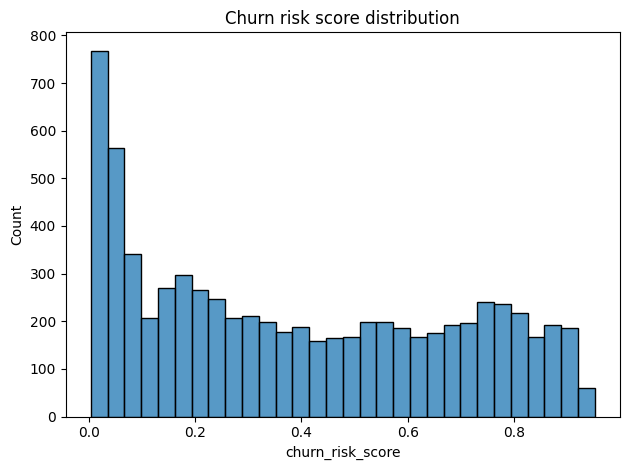

In [20]:
sns.histplot(out["churn_risk_score"], bins=30)
plt.title("Churn risk score distribution")
plt.tight_layout(); plt.savefig("figures/risk_distribution.png"); plt.show()

if "contract_type" in out.columns:
    out.groupby("contract_type")["churn_risk_score"].mean().sort_values(ascending=False).plot(kind="bar")
    plt.title("Avg risk by contract_type")
    plt.tight_layout(); plt.savefig("figures/risk_by_contract_type.png"); plt.show()

In [21]:
# data drift

def compute_psi(base: pd.Series, new: pd.Series, bins=10):
    base = base.replace([np.inf,-np.inf], np.nan).dropna()
    new  = new.replace([np.inf,-np.inf], np.nan).dropna()
    if base.nunique() < 2 or new.nunique() < 2: return 0.0
    cuts = np.quantile(base, np.linspace(0,1,bins+1))
    cuts = np.unique(cuts)
    base_counts = np.histogram(base, bins=cuts)[0] + 1e-6
    new_counts  = np.histogram(new,  bins=cuts)[0] + 1e-6
    base_pct, new_pct = base_counts/base_counts.sum(), new_counts/new_counts.sum()
    return float(np.sum((new_pct - base_pct) * np.log(new_pct / base_pct)))

num_cols_monitor = X_train.select_dtypes(include=np.number).columns
pd.Series({c: compute_psi(X_train[c], X_test[c]) for c in num_cols_monitor if c in X_test.columns}).sort_values(ascending=False).to_csv("reports/psi_top_shifts.csv")
print("Saved drift PSI report.")

Saved drift PSI report.


In [ ]:
script = """\
import pandas as pd, joblib

MODEL = "models/final_churn_model.joblib"
INP   = "data/raw/new_customers.csv"
OUT   = "data/processed/scored_batch.csv"

model = joblib.load(MODEL)
df = pd.read_csv(INP)  # must match training schema (same column names)
proba = model.predict_proba(df)[:,1]
df_out = df.copy(); df_out["churn_risk_score"] = proba
df_out.to_csv(OUT, index=False)
print("Wrote:", OUT)
"""
open("run_scoring.py","w").write(script)
print("Wrote run_scoring.py")

Wrote run_scoring.py


In [22]:
guide = f"""
Stakeholder Guidance — Churn Prediction

Use
- File: data/processed/churn_scored_for_crm.csv
- Columns: churn_risk_score (0–1), risk_tier (Low/Moderate/High/Critical), recommended_action.

Operate
- Prioritize Critical and High for outreach; Moderate via email/survey; Low via nurture.
- Threshold chosen to meet precision target when feasible; else best F1.

Quality (holdout)
- AUC: {auc:.3f}
- Precision @ thr {chosen_thr:.3f}: {precision_score(y_test,y_pred_test):.3f}
- Recall @ thr {chosen_thr:.3f}: {recall_score(y_test,y_pred_test):.3f}
- F1: {f1_score(y_test,y_pred_test):.3f}

Notes
- Stratified train/test split; preprocessing inside the saved pipeline.
- Retrain quarterly or on drift (see reports/psi_top_shifts.csv).
"""
open("reports/stakeholder_guide.md","w").write(guide)
print("Saved stakeholder guide.")

Saved stakeholder guide.
